# Imports

In [1389]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from lightgbm import LGBMRegressor
from scipy import stats
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Functions

In [1390]:
def random_forest_regressor(x_train, x_test, y_train, y_test, scaler):
    params = {
        "n_estimators": [500],  # range(10, 1000, 10),
        # ["squared_error", "absolute_error", "poisson"],
        "criterion": ["poisson"],
        "max_depth": [50],  # range(5, 50, 5),
        "min_samples_leaf": [5],  # range(5, 50, 5),
        "min_samples_split": [25],  # range(5, 50, 5),
        "max_features": ["sqrt"],  # [None, "sqrt", "log2"],
        "bootstrap": [False]  # [True, False]
    }

    rtr = RandomForestRegressor(n_jobs=-1, random_state=rnd)
    clf = GridSearchCV(
        rtr, cv=4, scoring=("r2", "neg_root_mean_squared_error"),
        param_grid=params, n_jobs=-1, refit='r2')

    pipeline = make_pipeline(scaler, clf)
    pipeline.fit(x_train, y_train)

    prediction_train = pipeline.predict(x_train)
    prediction_test = pipeline.predict(x_test)

    train_score = (r2_score(y_train, prediction_train),
                   mean_squared_error(y_train, prediction_train))
    test_score = (r2_score(y_test, prediction_test),
                  mean_squared_error(y_test, prediction_test))

    return pipeline, train_score, test_score


def gradient_boosting_regressor(x_train, x_test, y_train, y_test, scaler):
    params = {
        "n_estimators": [300],  # [100, 200, 300],
        "max_depth": [3],  # [3 ,4, 5, 10],
        "learning_rate": [0.03]  # [0.01, 0.02, 0.03, 0.1, 0.2]
    }

    gbr = GradientBoostingRegressor(
        criterion="squared_error", random_state=rnd)
    clf = GridSearchCV(
        gbr, cv=4, scoring=("r2", "neg_root_mean_squared_error"),
        param_grid=params, n_jobs=-1, refit='r2')

    pipeline = make_pipeline(scaler, clf)
    pipeline.fit(x_train, y_train)

    prediction_train = pipeline.predict(x_train)
    prediction_test = pipeline.predict(x_test)

    train_score = (r2_score(y_train, prediction_train),
                   mean_squared_error(y_train, prediction_train))
    test_score = (r2_score(y_test, prediction_test),
                  mean_squared_error(y_test, prediction_test))

    return pipeline, train_score, test_score


def lightgbm_regressor(x_train, x_test, y_train, y_test, scaler):
    params = {
        "n_estimators": [100],  # [100, 200, 300],
        "max_depth": [3],  # [3 ,4, 5, 10],
        "min_child_samples": [10],  # [10, 20, 15, 25, 50],
        "learning_rate": [0.03]  # [0.01, 0.02, 0.03, 0.1, 0.2]
    }

    lgb = LGBMRegressor(random_state=rnd)
    clf = GridSearchCV(
        lgb, cv=4, scoring=("r2", "neg_root_mean_squared_error"),
        param_grid=params, n_jobs=-1, refit='r2')

    pipeline = make_pipeline(scaler, clf)
    pipeline.fit(X_train, y_train)

    prediction_train = pipeline.predict(x_train)
    prediction_test = pipeline.predict(x_test)

    train_score = (r2_score(y_train, prediction_train),
                   mean_squared_error(y_train, prediction_train))
    test_score = (r2_score(y_test, prediction_test),
                  mean_squared_error(y_test, prediction_test))

    return pipeline, train_score, test_score


# Settings

In [1391]:
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.dpi'] = 200

rnd = 0
np.random.seed(rnd)

train_path = "./data/train.csv"
test_path = "./data/test.csv"
result_path = "./results/"

# EDA

In [1392]:
train_data = pd.read_csv(train_path)
print(f"Количество строк - {train_data.shape[0]}, количество столбцов - \
{train_data.shape[1]}.")
train_data.head()

Количество строк - 204, количество столбцов - 41.


,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,0,0.653951,0.190447,0.809904,0.859124,0.984938,0.994901,1.885449,NaN,NaN,...,5.504695,0.938391,15.956818,1.447808,2.974913,0.285216,0.352916,0.405002,0.142003,4.055409
1,1,0.353398,0.136217,0.776009,0.846753,1.252512,1.014782,1.779742,NaN,NaN,...,3.976763,3.573699,13.359336,0.808396,2.974913,0.285216,0.283933,0.405002,0.142003,3.586623
2,2,0.401805,0.108167,0.911589,0.853978,1.118725,1.022858,1.888858,NaN,NaN,...,3.976763,3.573699,12.493509,1.447808,3.690771,0.746143,0.283933,0.405002,0.142003,3.868643
3,3,1.395095,0.095700,0.945483,0.848831,1.088995,0.971914,1.904203,NaN,NaN,...,3.976763,2.695263,12.493509,2.087220,3.690771,0.285216,0.283933,0.405002,0.142003,4.161027
4,4,1.018771,0.250911,0.908981,0.858629,1.029534,1.037769,1.812136,0.226717,0.83435,...,3.976763,3.573699,9.030200,1.021533,3.690771,0.746143,0.421900,0.405002,0.142003,4.255913


Удалим лишнюю колонку с индесами, полученную при чтении из CSV файла, а также удалим дублирующиеся строки если таковые имеются.

In [1393]:
train_data = train_data.drop("Unnamed: 0", axis=1).drop_duplicates()
print(f"Количество строк - {train_data.shape[0]}, количество столбцов - \
{train_data.shape[1]}.")
train_data.head()

Количество строк - 203, количество столбцов - 40.


,1,2,3,4,5,6,7,8,9,10,...,31,32,33,34,35,36,37,38,39,40
0,0.653951,0.190447,0.809904,0.859124,0.984938,0.994901,1.885449,NaN,NaN,NaN,...,5.504695,0.938391,15.956818,1.447808,2.974913,0.285216,0.352916,0.405002,0.142003,4.055409
1,0.353398,0.136217,0.776009,0.846753,1.252512,1.014782,1.779742,NaN,NaN,NaN,...,3.976763,3.573699,13.359336,0.808396,2.974913,0.285216,0.283933,0.405002,0.142003,3.586623
2,0.401805,0.108167,0.911589,0.853978,1.118725,1.022858,1.888858,NaN,NaN,NaN,...,3.976763,3.573699,12.493509,1.447808,3.690771,0.746143,0.283933,0.405002,0.142003,3.868643
3,1.395095,0.095700,0.945483,0.848831,1.088995,0.971914,1.904203,NaN,NaN,NaN,...,3.976763,2.695263,12.493509,2.087220,3.690771,0.285216,0.283933,0.405002,0.142003,4.161027
4,1.018771,0.250911,0.908981,0.858629,1.029534,1.037769,1.812136,0.226717,0.83435,0.013091,...,3.976763,3.573699,9.030200,1.021533,3.690771,0.746143,0.421900,0.405002,0.142003,4.255913


Посмотрим на колонки тренировочного датасета.

In [1394]:
train_data.columns

Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37',
       '38', '39', '40'],
      dtype='object')

Т.к. колонки обезличены, то никакой дополнительной информации они не дают.
Посмотрим на общую информацию о тренировочном датасете.

In [1395]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 203 entries, 0 to 203
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       203 non-null    float64
 1   2       202 non-null    float64
 2   3       202 non-null    float64
 3   4       202 non-null    float64
 4   5       202 non-null    float64
 5   6       202 non-null    float64
 6   7       201 non-null    float64
 7   8       99 non-null     float64
 8   9       99 non-null     float64
 9   10      99 non-null     float64
 10  11      99 non-null     float64
 11  12      99 non-null     float64
 12  13      201 non-null    float64
 13  14      201 non-null    float64
 14  15      99 non-null     float64
 15  16      201 non-null    float64
 16  17      201 non-null    float64
 17  18      201 non-null    float64
 18  19      201 non-null    float64
 19  20      99 non-null     float64
 20  21      99 non-null     float64
 21  22      99 non-null     float64
 22  23

Все 40 колонок (признаков) представляют из себя числа с плавающей точкой. Также можно видеть что некоторые колонки имеют более половины пропущенных значений.

In [1396]:
print(f'Количество колонок с пропущенными значениями - \
{train_data.isnull().any().sum()}.')

Количество колонок с пропущенными значениями - 38.


In [1397]:
missing_values_count = train_data.isnull().sum()
half_index = set(
    missing_values_count[missing_values_count > train_data.shape[0] / 2].index)
quarter_index = set(
    missing_values_count[missing_values_count >
                         train_data.shape[0] / 4].index) - half_index
print(f"Колонки в которых пропущено более 50% данных: {half_index}, \
их количество - {len(half_index)}.")
print(f"Колонки в которых пропущено более 25% данных: {quarter_index}, \
их количество - {len(quarter_index)}.")

Колонки в которых пропущено более 50% данных: {'25', '10', '9', '20', '21', '22', '8', '11', '15', '12'}, их количество - 10.
Колонки в которых пропущено более 25% данных: {'39', '38', '37'}, их количество - 3.


In [1398]:
total_cells = np.product(train_data.shape)
total_missing = missing_values_count.sum()
percent_missing = (total_missing / total_cells) * 100
print(f"Общий процент пропущенных данных - \
{'{:.4f}'.format(percent_missing)}%.")

Общий процент пропущенных данных - 15.6034%.


Удалим все колонки у которых более 25% пропущенных данных, в остальных колонках заменим данные на среднее значение колонки.

In [1399]:
train_data.drop([*list(half_index), *list(quarter_index)],
                axis=1, inplace=True)

In [1400]:
train_data.fillna(train_data.mean(), inplace=True)

In [1401]:
print(f"После очистки данных, количество строк - {train_data.shape[0]}, \
количество колонок - {train_data.shape[1]}.")
print(f'Количество колонок с пропущенными значениями - \
{train_data.isnull().any().sum()}.')

После очистки данных, количество строк - 203, количество колонок - 27.
Количество колонок с пропущенными значениями - 0.


In [1402]:
train_data.describe()

,1,2,3,4,5,6,7,13,14,16,...,28,29,30,31,32,33,34,35,36,40
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,...,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000
mean,0.946477,0.150746,0.886716,0.850001,0.925355,1.016873,1.872335,1.232063,1.867455,1.053842,...,33.053866,2.961813,1.910121,3.417026,2.329973,11.992015,1.670441,3.630525,0.365079,4.172165
std,1.270448,0.077545,0.097045,0.009188,0.160958,0.053578,0.123957,0.110044,0.414635,0.138259,...,6.337518,1.047660,1.043067,1.127532,1.302446,2.958972,0.652743,1.103003,0.191686,0.336436
min,0.167198,0.067338,0.562211,0.837746,0.647994,0.847659,0.826680,0.971139,1.120934,0.803570,...,12.915762,0.629927,0.582570,1.430210,0.059955,4.701064,0.808396,0.827340,0.285216,3.273262
25%,0.440409,0.095638,0.837281,0.843586,0.809033,0.984339,1.826628,1.161443,1.594026,0.992547,...,28.969409,2.214145,1.367827,2.448831,0.938391,9.896028,1.128102,2.974913,0.285216,3.919040
50%,0.653951,0.124997,0.903767,0.848237,0.905657,1.009190,1.893973,1.228130,1.756893,1.034030,...,33.347677,2.742218,1.367827,3.467452,1.816827,11.627682,1.660945,3.690771,0.285216,4.192216
75%,0.990038,0.184837,0.952002,0.853681,1.019624,1.039633,1.942564,1.306204,2.063239,1.073208,...,37.239470,3.270291,2.153084,3.976763,3.573699,13.792250,2.193789,4.406628,0.285216,4.436236
max,12.097211,0.464715,1.172318,0.896734,1.465580,1.283172,2.067877,1.540424,3.804371,2.250854,...,48.914850,8.551018,5.294112,7.541937,5.330571,22.883435,3.579181,7.270059,1.207070,4.919254


Выделим целевое значение в отдельную переменную для удобства.

In [1403]:
train_y = train_data["40"]

Посмотрим на распределение целевого значения.

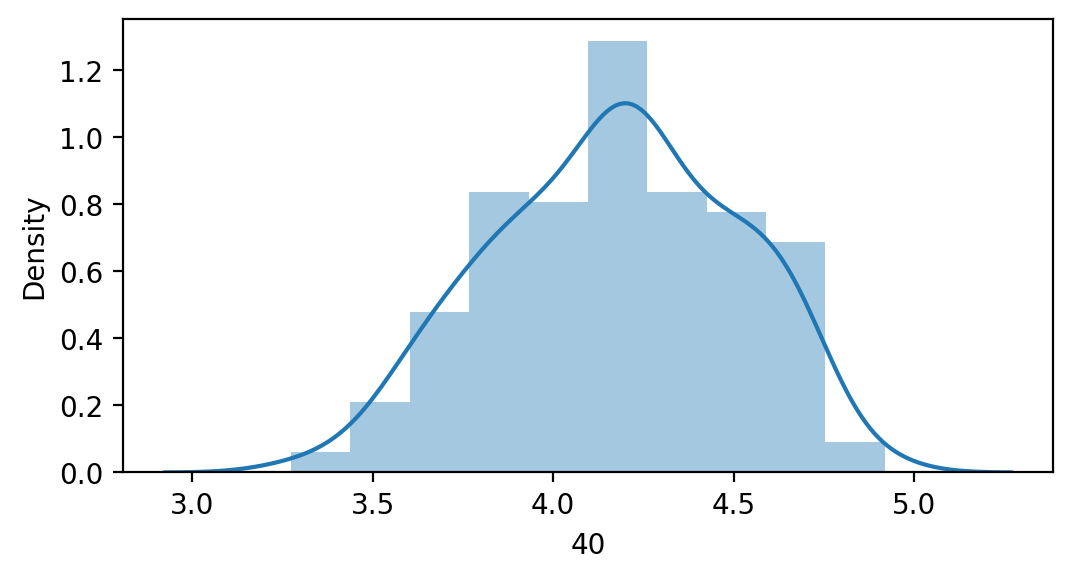

In [1404]:
plt.figure(figsize=(6, 3))
sns.distplot(train_y, bins=10);

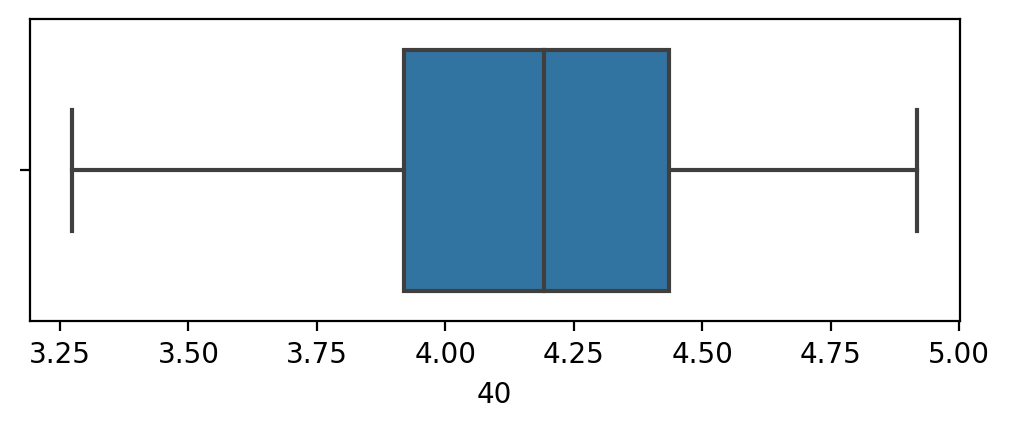

In [1405]:
plt.figure(figsize=(6, 2))
sns.boxplot(train_y);

In [1406]:
k2, p = stats.normaltest(train_y)
alpha = 0.05
print("Нелевая гипотеза - целевое значение имеет нормальное распределение.")
if p < alpha:
    print(f"Нулевая гипотеза может быть отвергнута, т.к. {p} < {alpha}.")
else:
    print(f"Нулевая гипотеза не может быть отвергнута, т.к. {p} < {alpha}.")

Нелевая гипотеза - целевое значение имеет нормальное распределение.
Нулевая гипотеза может быть отвергнута, т.к. 0.03276594033734488 < 0.05.


In [1407]:
train_y.skew()

-0.1599252692342983

Распределение целевого значений смещено влево.

### Numerical data distribution
For this part lets look at the distribution of all of the features by ploting them.

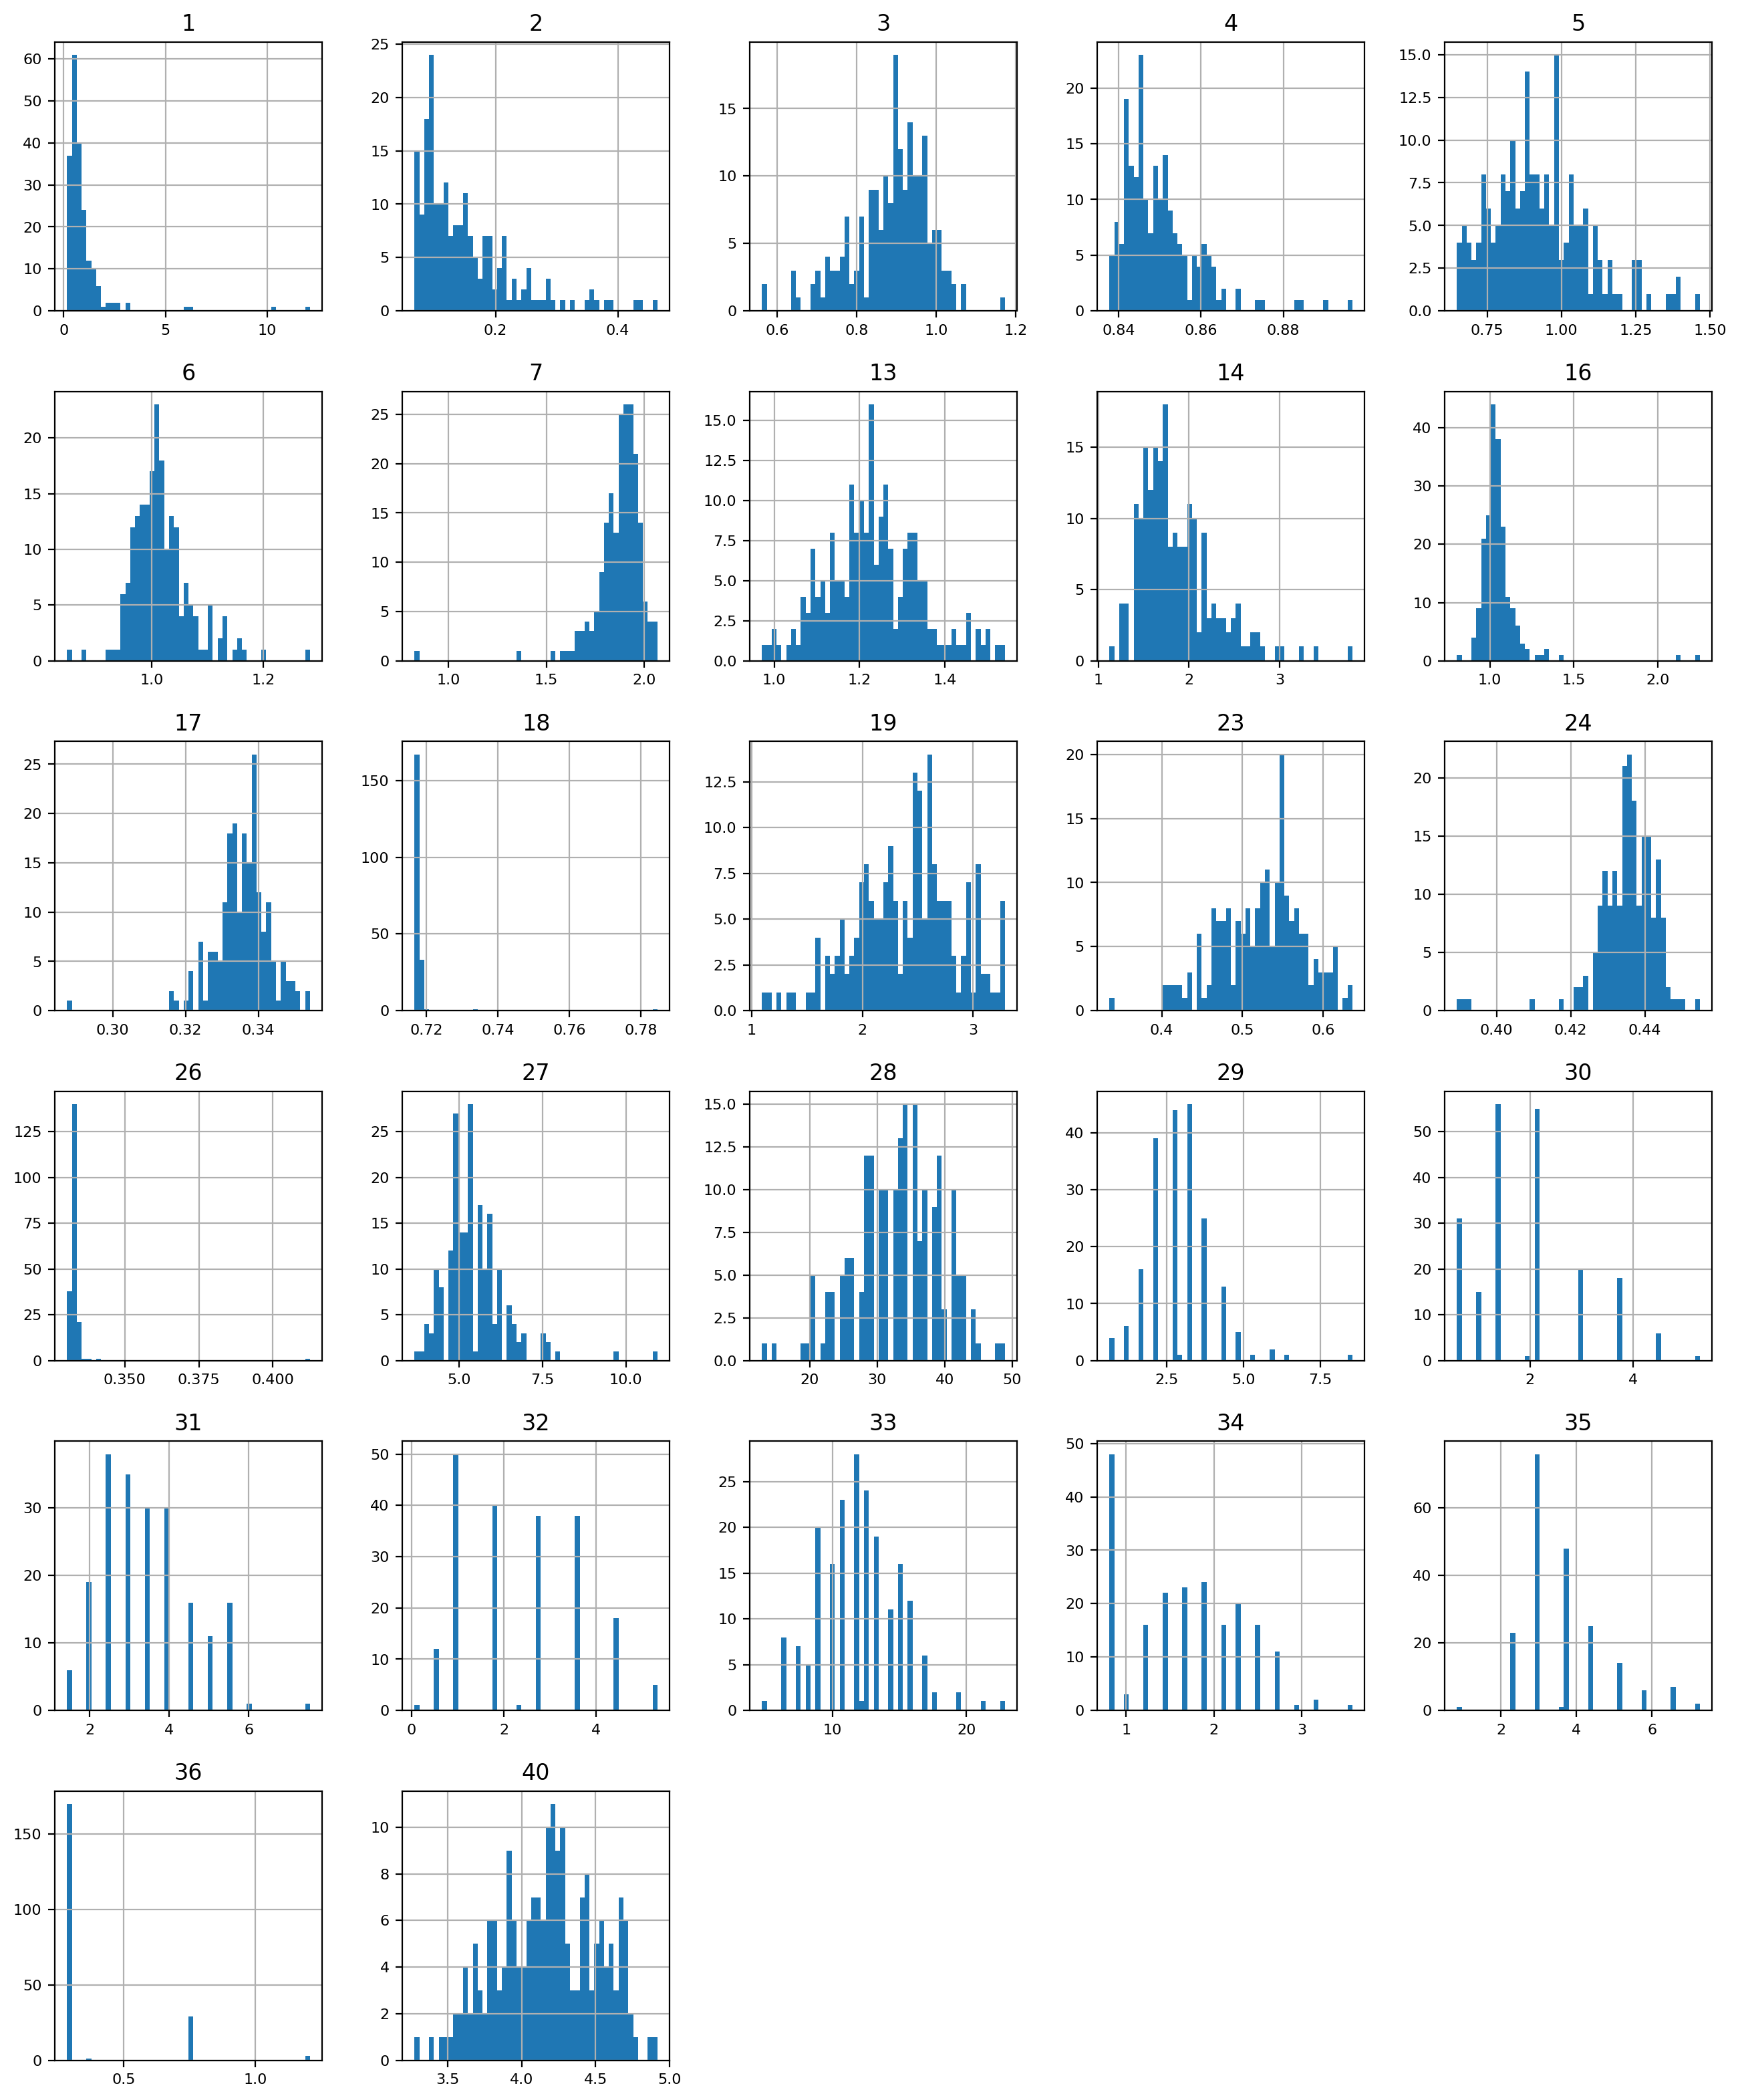

In [1408]:
train_data.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

### Correlation
Теперь попробуем посмотреть, какие признаки сильно коррелируют с «40».

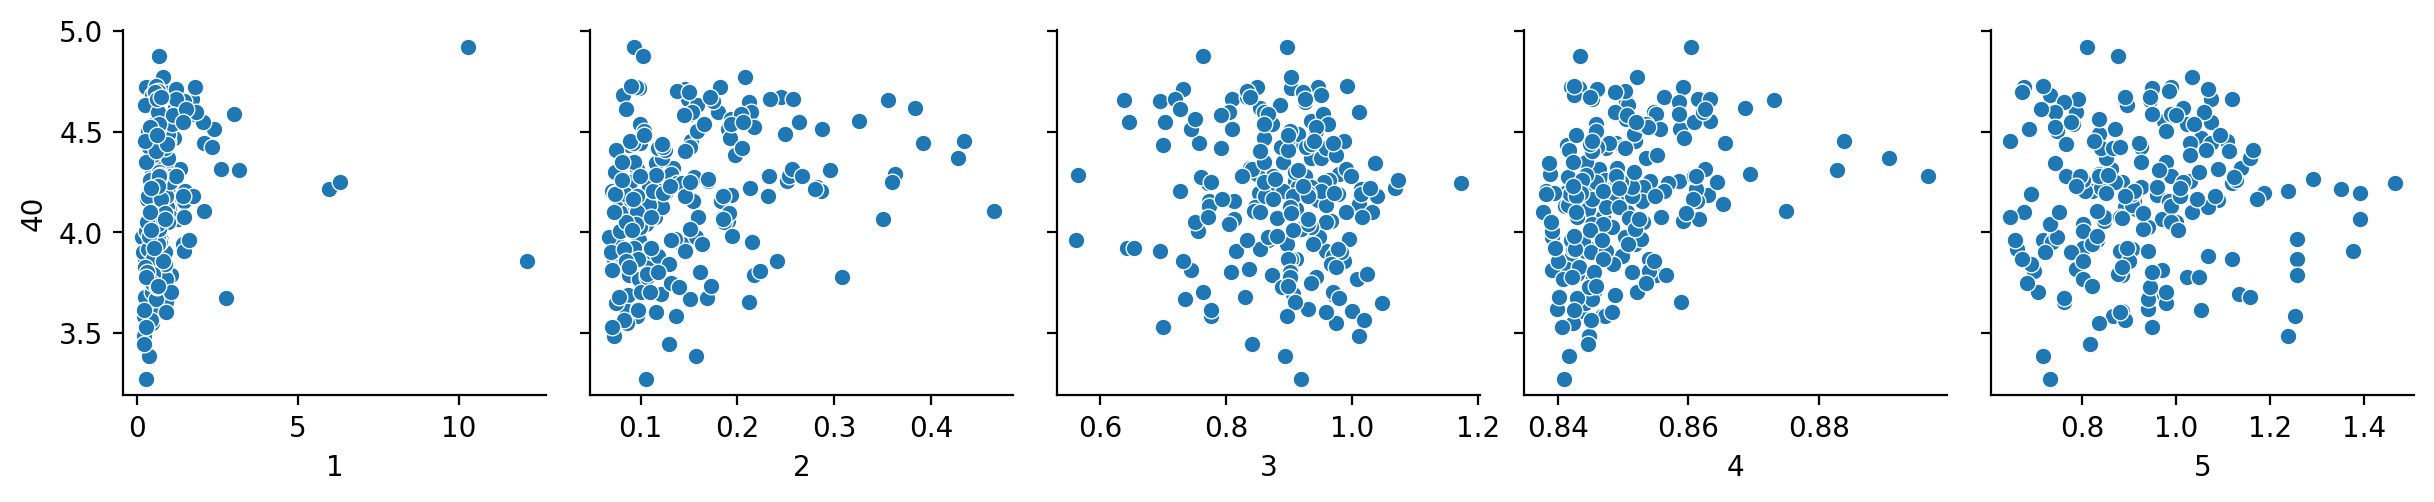

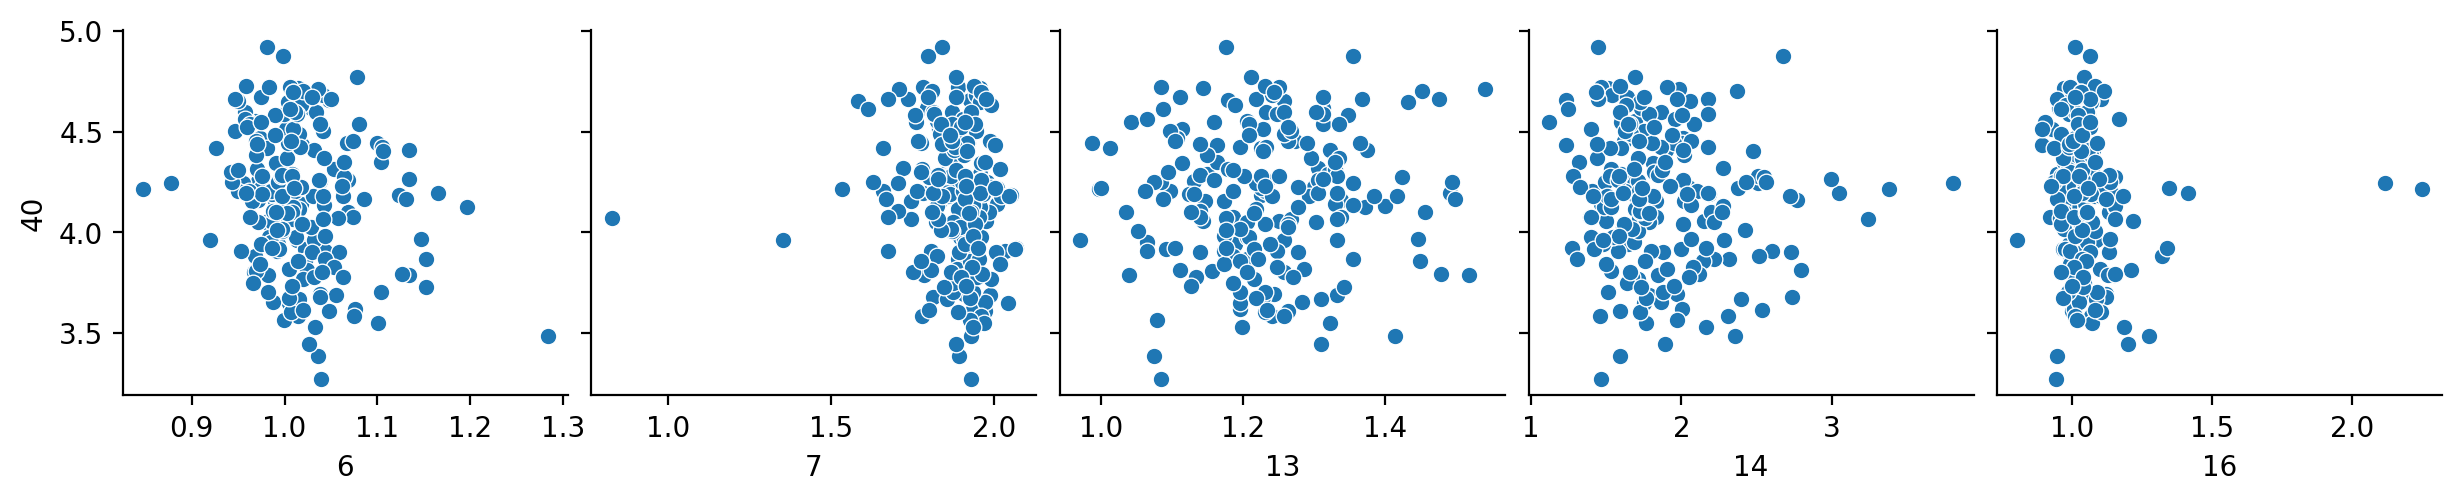

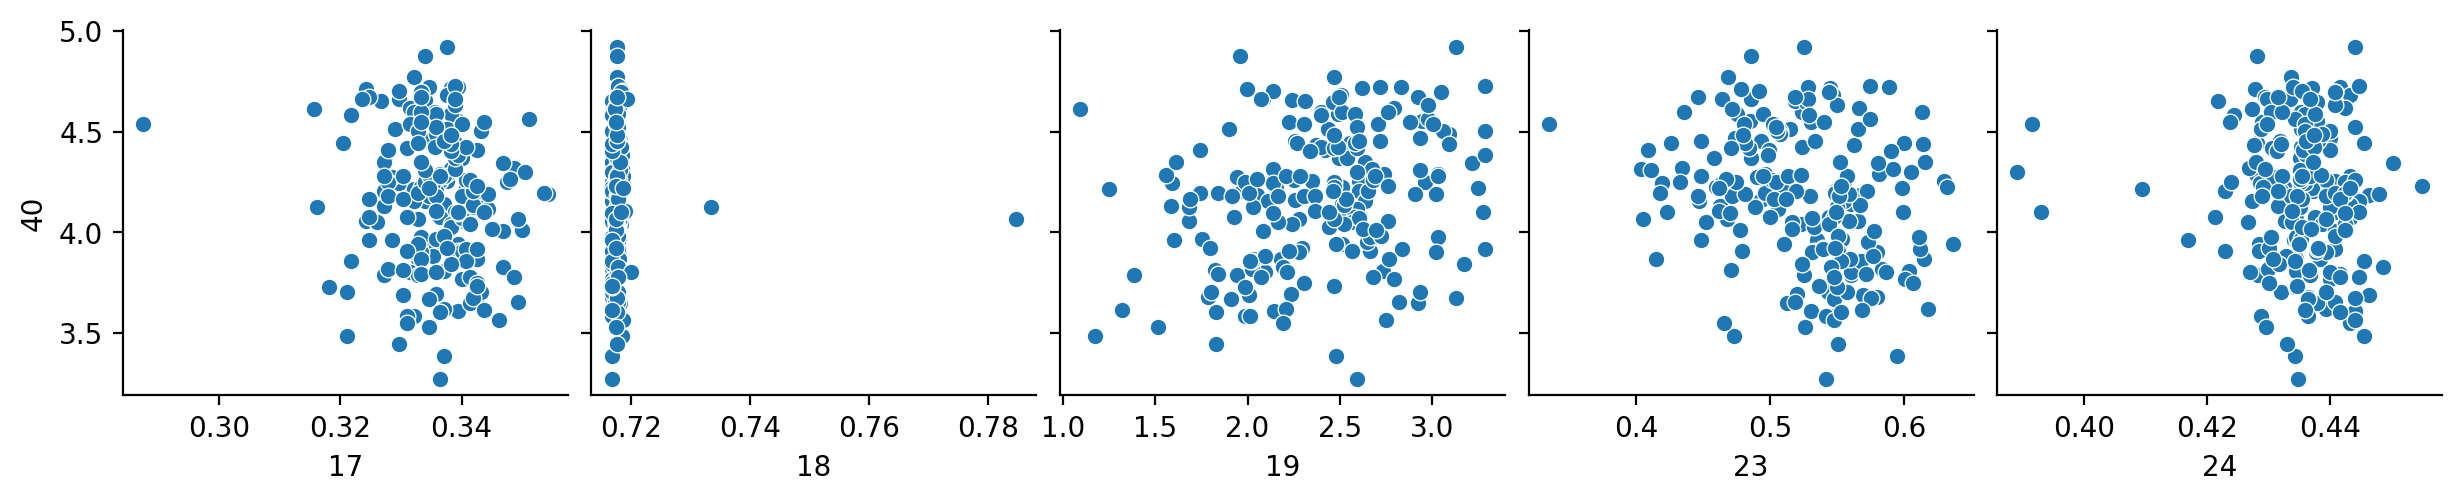

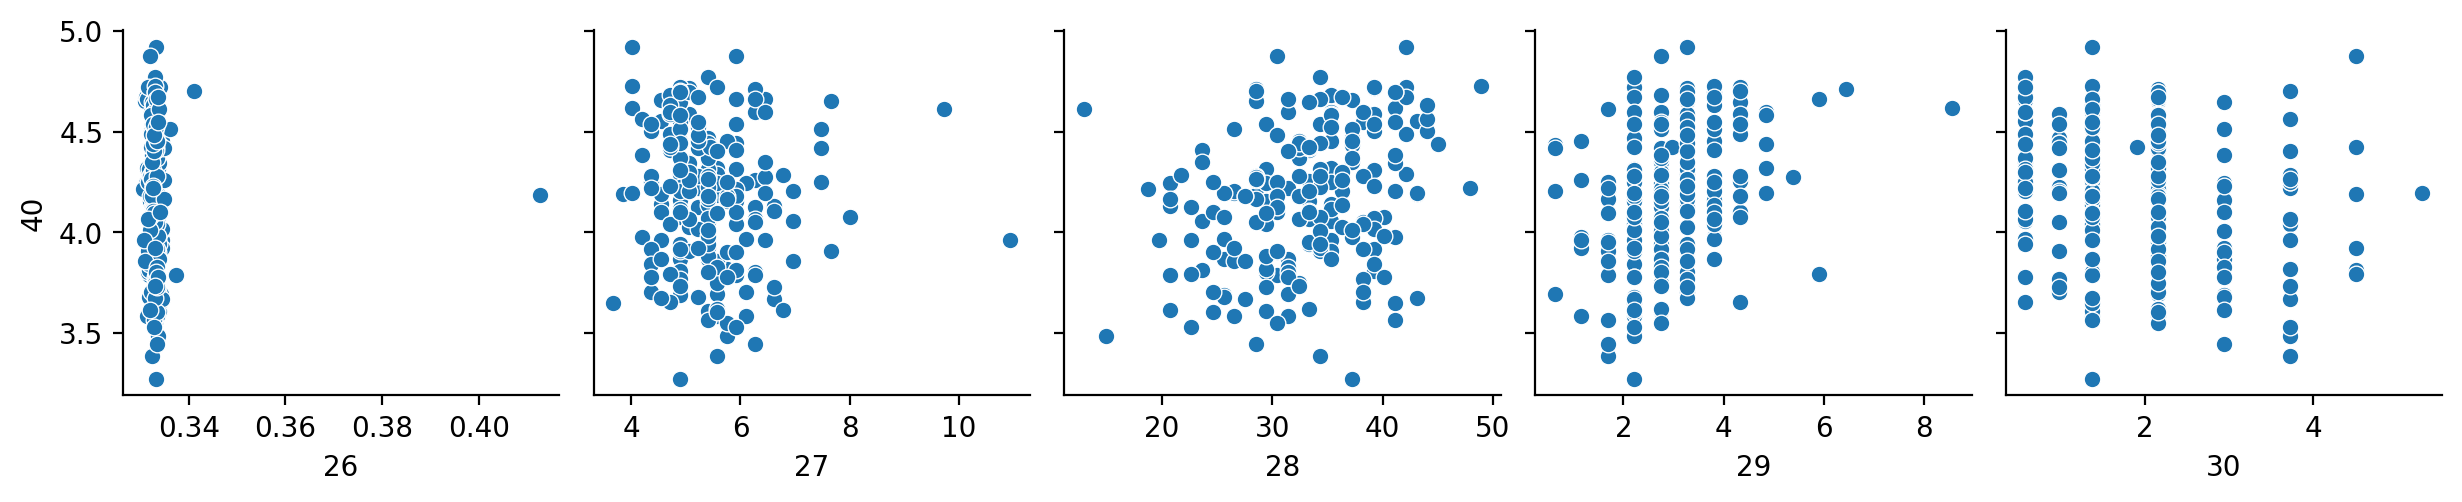

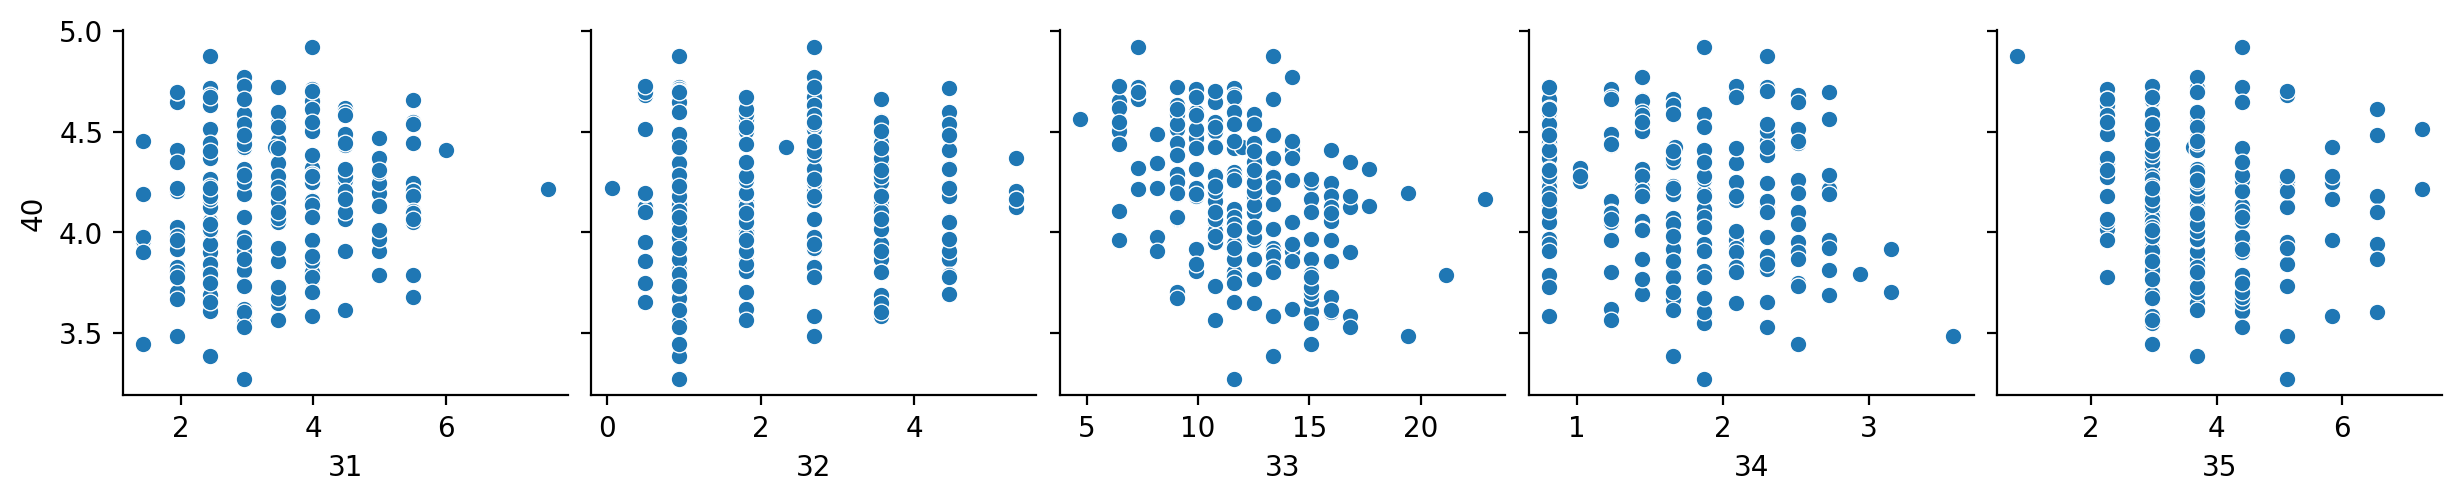

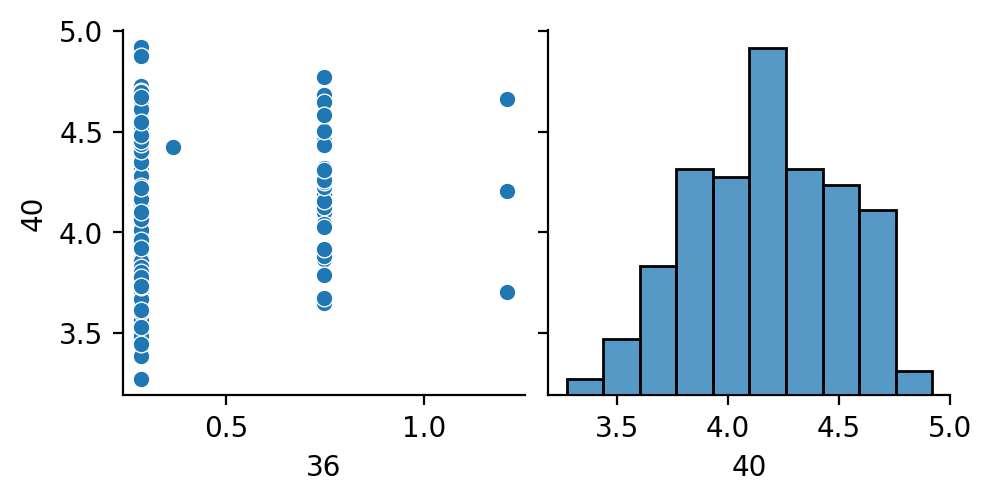

In [1409]:
for i in range(0, len(train_data.columns), 5):
    sns.pairplot(data=train_data,
                 x_vars=train_data.columns[i:i+5],
                 y_vars=['40'])

Никаких наглядных зависимстей не видно. В данных присутствую некоторые выбросы.

In [1410]:
# Удалим колонки данны в которых визуально не имеют зависимости с "40"
to_drop_corr_y = ["1", "17", "27", "30", "31", "32", "34", "35", "36"]
train_data_clear = train_data.drop(to_drop_corr_y, axis=1)

# Feature to feature relationship

<AxesSubplot:>

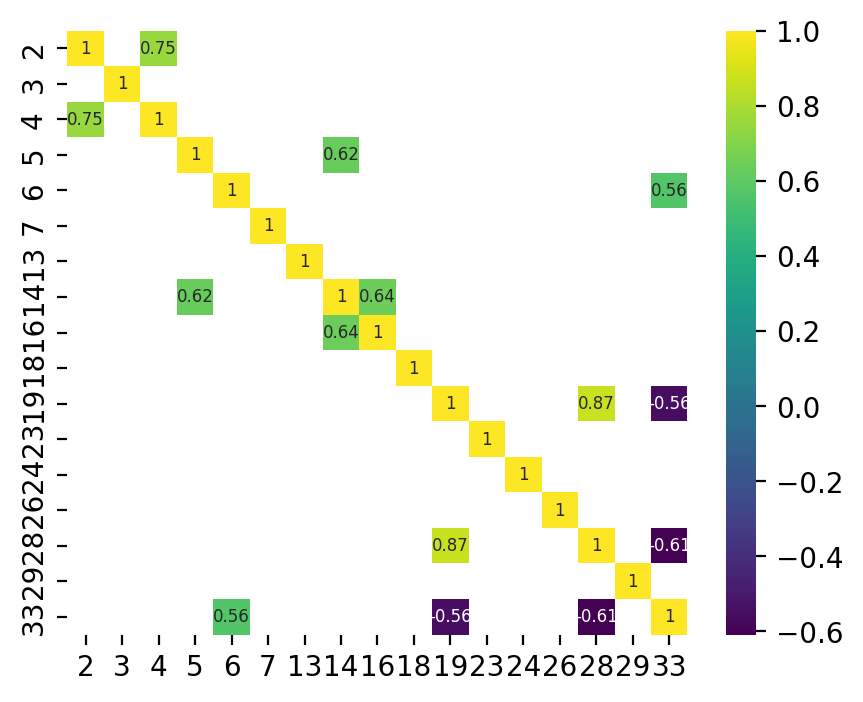

In [1411]:
# We already examined "40" correlations
corr = train_data_clear.drop("40", axis=1).corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], cmap='viridis',
            annot=True, annot_kws={"size": 6})

Мы можем видеть высокую корреляцию между некоторыми признаками. Удалим колонки с высокой корреляцией.

In [1412]:
to_drop_corr_x = ["4", "6", "14", "19", "28"]
train_data_clear = train_data_clear.drop(to_drop_corr_x, axis=1)

<AxesSubplot:>

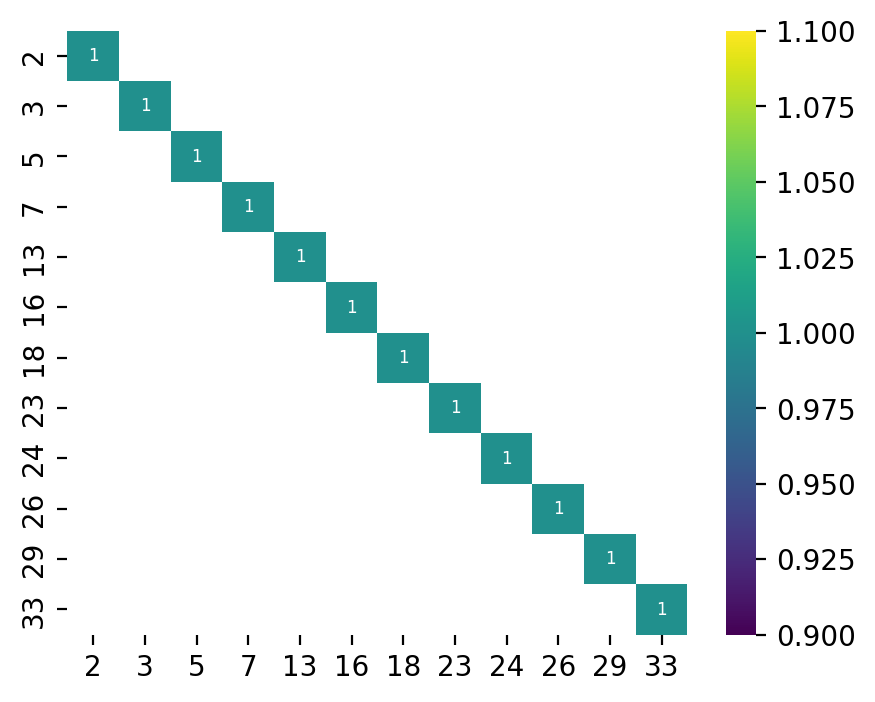

In [1413]:
# We already examined "40" correlations
corr = train_data_clear.drop('40', axis=1).corr()

plt.figure(figsize=(5, 4))
sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.5)], cmap='viridis',
            annot=True, annot_kws={"size": 6})

# Models

In [1414]:
y = train_data_clear["40"]
X = train_data_clear.drop("40", axis=1)

In [1415]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=rnd)

In [1416]:
scaler = StandardScaler()

In [1417]:
pipe_rfr, train_score, test_score = random_forest_regressor(
    X_train, X_test, y_train, y_test, scaler)

In [1418]:
res_list = [["Random Forest", *train_score, *test_score]]

# Gradient Boosting

In [1419]:
pipe_gbr, train_score, test_score = gradient_boosting_regressor(
    X_train, X_test, y_train, y_test, scaler)

In [1420]:
res_list.append(["Gradient Boosting", *train_score, *test_score])

# LGBMRegressor

In [1421]:
pipe_lgbmr, train_score, test_score = lightgbm_regressor(
    X_train, X_test, y_train, y_test, scaler)

In [1422]:
res_list.append(["LGBMRegressor", *train_score, *test_score])

# Results

In [1423]:
res_df = pd.DataFrame(res_list,
                      columns=["Model", "Train - R2", "Train - RMSE",
                               "Test - R2", "Test - RMSE"]
                      )
res_df.sort_values("Test - R2", ascending=False)

,Model,Train - R2,Train - RMSE,Test - R2,Test - RMSE
1,Gradient Boosting,0.955635,0.005073,0.423659,0.062490
2,LGBMRegressor,0.695736,0.034791,0.401281,0.064916
0,Random Forest,0.597513,0.046023,0.307301,0.075106


Обучим Gradient Boosting на всем наборе данных, т.к. она показывает наилучший результат как на тренировочных так и на тестовых данных.

In [1424]:
model = pipe_gbr.fit(X, y)

Интерпритируем ее результаты.

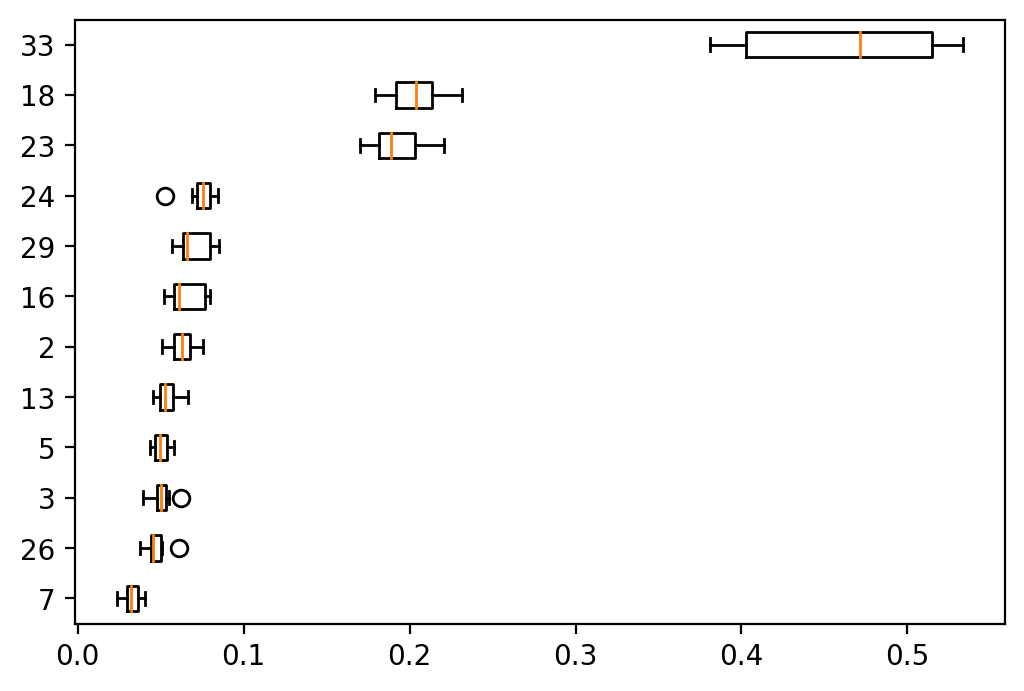

In [1425]:
result = permutation_importance(
    model, X, y, n_repeats=10, random_state=0)
sorted_idx = result.importances_mean.argsort()
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X.columns)[sorted_idx],
);

# Predict

Преобразуем тестовые данные также как и тренировочные.

In [1426]:
test_data = pd.read_csv(test_path).drop("Unnamed: 0", axis=1)
test_data.head()

,1,2,3,4,5,6,7,8,9,10,...,30,31,32,33,34,35,36,37,38,39
0,1.251801,0.158034,0.888123,0.854473,1.009714,0.968807,1.807021,NaN,NaN,NaN,...,0.582570,4.995384,4.452135,9.030200,0.808396,2.259055,0.285216,0.352916,0.405002,0.142003
1,0.347331,0.091773,0.919410,0.841408,0.638083,1.027207,2.072992,0.226607,0.831712,0.013091,...,2.153084,1.430210,0.499173,10.761855,2.513494,2.974913,0.285216,NaN,NaN,NaN
2,0.427033,0.217874,0.976771,0.857739,0.742140,0.982476,1.888858,0.226607,0.835168,0.013091,...,2.153084,2.958142,0.938391,9.030200,2.513494,2.974913,0.285216,0.352916,0.405002,0.142003
3,0.600732,0.286441,0.979378,0.853087,0.940343,1.001735,2.025254,0.226607,0.831621,0.013091,...,0.582570,2.958142,2.695263,13.359336,0.808396,1.543197,0.285216,NaN,NaN,NaN
4,0.963893,0.736490,0.937661,0.908610,1.168276,1.332874,1.875219,0.228466,0.833804,0.013091,...,0.582570,4.486074,3.573699,16.822645,0.808396,2.974913,1.207070,0.421900,0.405002,0.142003


In [1427]:
test_data.drop([*list(half_index), *list(quarter_index),
                *to_drop_corr_y, *to_drop_corr_x], axis=1, inplace=True)
test_data.fillna(test_data.mean(), inplace=True)

Используем лучшую по показателю R^2 модель.

In [1428]:
test_pred = model.predict(test_data)

In [1429]:
result = pd.Series(test_pred)
result.to_csv("results/test_prediction.csv", index=False, header=False)